# Classification d’images:
Nous allons construire un modèle de base pour classer les images en fonction de leurs caractéristiques HOG. Ce projet va vous permettre de mettre en place des mécanismes d’automatisation de pipeline de données et de recherche de paramètres optimaux pour des modèles de classification. Cette méthodologie est générique et
peut être appliquée à toutes sortes de problèmes d'apprentissage automatique.

## Tutoriel: classification d'images avec scikit-learn

    Dans ce didacticiel, nous allons configurer un pipeline d'apprentissage automatique dans scikit-learn pour prétraiter les données et entraîner un modèle. Comme cas de test, nous classerons les photos d'animaux, mais bien sûr, les méthodes décrites peuvent être appliquées à toutes sortes de problèmes d'apprentissage automatique.
    
    
## J'importe tous les modules necessaires 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)
import joblib
from skimage.io import imread
from skimage.transform import resize
from collections import Counter
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer,MinMaxScaler,MaxAbsScaler
import skimage
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB , BernoulliNB
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

# Préparation de l'ensemble de données

    Définissez une fonction pour lire, redimensionner et stocker les données dans un
    dictionnaire, contenant les images, les étiquettes (animal), les noms de fichiers
    originaux et une description.


In [4]:
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:-4])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)    
# modify to fit your system
data_path = fr'{os.getenv("HOME")}/Musique/LaPlateforme_Jobs/classification_image/AnimalFace/Image'
#os.listdir(data_path)

base_name = 'animal_faces'
width = 80
 
include = {'ChickenHead', 'BearHead', 'ElephantHead', 
           'EagleHead', 'DeerHead', 'MonkeyHead', 'PandaHead'}
 
resize_all(src=data_path, pklname=base_name, width=width, include=include)



 #Chargeons les données du disque et imprimons un résumé.


data = joblib.load(f'{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label'])) 
print(Counter(data['label']))


MonkeyHead
BearHead
ElephantHead
PandaHead
EagleHead
DeerHead
ChickenHead
number of samples:  716
keys:  ['description', 'label', 'filename', 'data']
description:  resized (80x80)animal images in rgb
image shape:  (80, 80, 3)
labels: ['Bear' 'Chicken' 'Deer' 'Eagle' 'Elephant' 'Monkey' 'Panda']
Counter({'Panda': 117, 'Bear': 101, 'Deer': 101, 'Monkey': 100, 'Elephant': 100, 'Chicken': 100, 'Eagle': 97})


Notez que cette étape n'est pas requise chaque fois que vous exécutez le notebook car les données sont stockées sous forme de pkl, qui peut être chargé directement la prochaine fois.
# Les images ci-dessous montrent un exemple de chaque animal inclus.

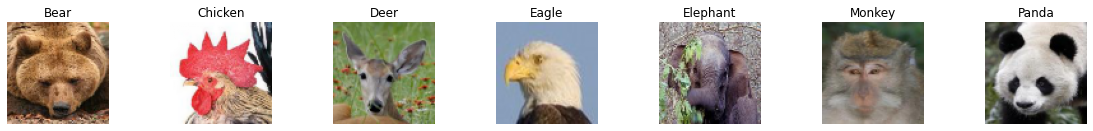

In [5]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(16,2)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)
    #plt.pause(1)

plt.show()  

## Par convention, nous nommons les données d'entrée X et le résultat (étiquettes / labels) y.

In [6]:
#Par convention, nous nommons les données d'entrée X et le résultat (étiquettes / labels) y.
X = np.array(data['data'])
y = np.array(data['label'])

### Ensuite, nous devons diviser nos données en un ensemble de test et un ensemble d'apprentissage.
Nous utilisons la fonction train_test_split de scikit-learn et utilisons 80% de l'ensemble total pour l'entraînement et le reste pour l'ensemble de test.

In [7]:
#6. Diviser vos données en un ensemble de test et un ensemble de train
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
)


La fonction “train_test_split” de sklearn fournit un paramètre shuffle ce qui nous permet d'égaliser les distributions dans l'ensemble de train et de test.

## Vérification de la distribution des photos dans l'ensemble de la formation et de test est similaire, (examiner le nombre relatif de photos par catégorie).

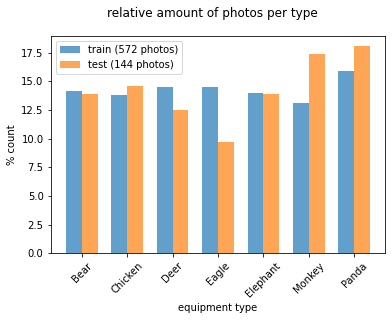

In [8]:
#Pour vérifier que la distribution des photos dans l'ensemble de formation et de test est similaire, regardons le nombre relatif de photos par catégorie.
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)


plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))])

plt.show()


Je constate que la distribution est similaire mais on n'a pas le meme éqiulibre dans les deux échantillons sur chaque groupe.
## Pour une amélioration supplémentaire, nous pourrions également utiliser le paramètre stratify de  train_test_split  pour garantir des distributions égales dans l'ensemble d'apprentissage et de test.

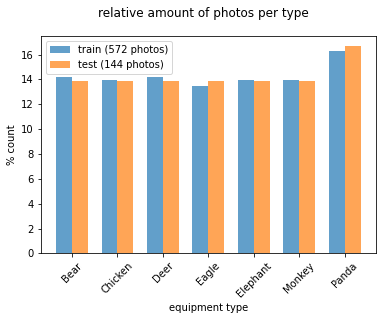

In [9]:
#Pour une amélioration supplémentaire, nous pourrions également utiliser le paramètre stratify de  
#train_test_split  pour garantir des distributions égales dans l'ensemble d'apprentissage et de test.

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    stratify=y,
    random_state=42)

plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))])
plt.show()


Les distributions sont quasi parfaitement égales et suffisantes pour le moment.
# Traitement des données
    Une approche classique de la reconnaissance d'objets est HOG-SVM, qui signifie Histogramme des dégradés orientés (Histogram of Oriented Gradients) et Support Vector Machines.
    
### Ici, nous devons convertir les images couleur en niveaux de gris, calculer leurs HOG et enfin mettre à l'échelle les données. Pour cela, nous utilisons troistransformateurs à la suite: RGB2GrayTransformer, HOGTransformer et StandardScaler. Le résultat final est un tableau avec un HOG pour chaque image del'entrée.

In [10]:
#Créer vos classes RGB2GrayTransformer and HOGTransformer
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 ##################################################################################################
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

Après avoir instancié chaque transformateur (RGB2GrayTransformer(), HogTransformer(),
StandardScaler())

### mettre à l’échelle votre échantillon de données en appelant fit_transform() à chaque transformation en convertissant X_train étape par étape (RGB2GrayTransformer, puis HogTransformer, puis StandardScaler).

In [11]:
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(572, 576)


## Entraîner un classifieur. 
Nous commencerons par Stochastic Gradient Descent (SGD), car il est rapide et fonctionne relativement bien.

In [12]:
#Nous créons d'abord une instance, puis nous appelons la méthode fit
#  en passant nos données d'entraînement et nos étiquettes.
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)


X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)
#Ensuite, nous faisons une prédiction pour notre ensemble de tests et examinons les résultats. Combien de prédictions correspondent à y_test?
y_pred = sgd_clf.predict(X_test_prepared)
print(np.array(y_pred == y_test)[:25])
print("avec SGDClassifier on a un ")
print('\nPercentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))


[ True  True  True False  True  True  True  True  True  True  True False
 False  True  True  True  True False  True False  True False  True  True
  True]
avec SGDClassifier on a un 

Percentage correct:  84.72222222222223


# Évaluer les faux positifs grâce à une matrice de confusion.
    La matrice de confusion pour le test SGD est une matrice 8 × 8. Comme ci-dessus, des prédictions correctes apparaissent sur la diagonale principale, alors que toutes les valeurs hors diagonale correspondent à des classifications incorrectes.

In [13]:
#Évaluer les faux positifs grâce à une matrice de confusion.
cmx = confusion_matrix(y_test, y_pred)
print("\nmatrice de SGDClassifier:\n",cmx)


matrice de SGDClassifier:
 [[18  0  0  0  1  1  0]
 [ 0 17  0  2  1  0  0]
 [ 2  0 18  0  0  0  0]
 [ 0  1  1 15  1  2  0]
 [ 2  0  0  1 17  0  0]
 [ 2  0  1  1  0 16  0]
 [ 1  0  0  1  0  1 21]]


Les valeurs les plus élevées sont sur la diagonale, donc la plupart des prédictions sont correctes, mais il y a des erreurs (~ 15%). Pour visualiser cela plus clairement sous forme d'image, nous faisons deux choses. Tout d'abord, nous normalisons la matrice à 100, en divisant chaque valeur par la somme de sa ligne (c'est-à-dire le nombre d'éléments réels avec une étiquette spécifique). Deuxièmement, nous définissons la diagonale principale à 0 afin de nous concentrer sur les mauvaises prédictions.

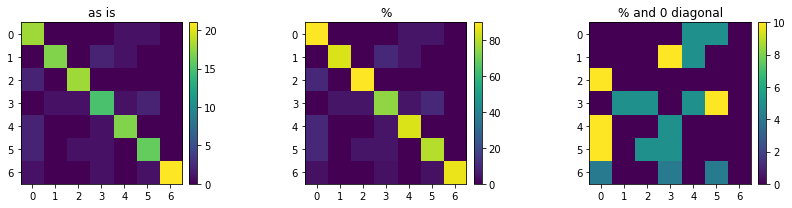


 ['Bear', 'Chicken', 'Deer', 'Eagle', 'Elephant', 'Monkey', 'Panda']


In [15]:

 
def plot_confusion_matrix(cmx, vmax1=None, vmax2=None, vmax3=None):
    cmx_norm = 100*cmx / cmx.sum(axis=1, keepdims=True)
    cmx_zero_diag = cmx_norm.copy()
 
    np.fill_diagonal(cmx_zero_diag, 0)
 
    fig, ax = plt.subplots(ncols=3)
    fig.set_size_inches(12, 3)
    [a.set_xticks(range(len(cmx)+1)) for a in ax]
    [a.set_yticks(range(len(cmx)+1)) for a in ax]
         
    im1 = ax[0].imshow(cmx, vmax=vmax1)
    ax[0].set_title('as is')
    im2 = ax[1].imshow(cmx_norm, vmax=vmax2)
    ax[1].set_title('%')
    im3 = ax[2].imshow(cmx_zero_diag, vmax=vmax3)
    ax[2].set_title('% and 0 diagonal')
 
    dividers = [make_axes_locatable(a) for a in ax]
    cax1, cax2, cax3 = [divider.append_axes("right", size="5%", pad=0.1) 
                        for divider in dividers]
 
    fig.colorbar(im1, cax=cax1)
    fig.colorbar(im2, cax=cax2)
    fig.colorbar(im3, cax=cax3)
    fig.tight_layout()
     
plot_confusion_matrix(cmx)
plt.show()
 
# the types appear in this order
print('\n', sorted(np.unique(y_test)))

Pour tirer des conclusions appropriées, nous devons souvent combiner ce que nous voyons dans la matrice de confusion avec ce que nous savons déjà sur les données. Par exemple, nous avons un pourcentage assez élevé d'aigles classés comme poulets. Aucune offense pour les aigles ou les poulets, mais dans cet ensemble, ils sont similaires. De plus, toutes les photos ne sont pas très claires, nous pourrions peut-être examiner différentes méthodes d'extraction de caractéristiques ou utiliser des images de résolution un peu plus élevée.

## En utilisant un pipeline, nous pouvons optimiser à la fois les transformations et leclassificateur en une seule procédure. De plus, au lieu de modifier manuellement les paramètres, nous pouvons utiliser un GridSearchCV.

In [16]:
#11. Mettre en place un pipeline qui pré-traite les données (RGB2GrayTransformer(),HogTransformer(), StandardScaler()),
#  ​ entraîne le modèle et nous permet de modifier les paramètres plus facilement.

 
HOG_pipeline = Pipeline([
    ('grayify', RGB2GrayTransformer()),
    ('hogify', HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        block_norm='L2-Hys')
    ),
    ('scalify', StandardScaler()),
    ('classify', SGDClassifier(random_state=42, max_iter=1000, tol=1e-3))
])
 
clf = HOG_pipeline.fit(X_train, y_train)
print("Resultats du SGDClassifier inclu dans un Pipeline ")
print('\nPercentage correct des train: ', 100*np.sum(clf.predict(X_train) == y_train)/len(y_train))

print('\nPercentage correct des tests: ', 100*np.sum(clf.predict(X_test) == y_test)/len(y_test))


Resultats du SGDClassifier inclu dans un Pipeline 

Percentage correct des train:  100.0

Percentage correct des tests:  84.72222222222223


### Pour cela, définir une grille de paramètres (param_grid = [{...}]).

In [17]:
#12. Pour cela, définir une grille de paramètres (param_grid = [{...}]).
print("\nChangement de parametres par train ou multi-parametres")
param_grid = [
    {
        'hogify__orientations': [8, 9],
        'hogify__cells_per_block': [(2, 2), (3, 3)],
        'hogify__pixels_per_cell': [(8, 8), (10, 10), (12, 12)]
    },
    {
        'hogify__orientations': [8],
         'hogify__cells_per_block': [(3, 3)],
         'hogify__pixels_per_cell': [(8, 8)],
         'scalify': [StandardScaler(),MaxAbsScaler(),MinMaxScaler(),Normalizer()],
         'classify': [
             SGDClassifier(random_state=42, max_iter=1000, tol=1e-3),
             svm.SVC(kernel='linear'),svm.SVC(kernel="poly"),
             GaussianNB()

         ]
    }
]


Changement de parametres par train ou multi-parametres


## Évaluation dans le même objet Grid Search, le classifieur SVM et le classifieur SGD


In [19]:
#13. Évaluer dans le même objet Grid Search, le classifieur SVM et le classifieur SGD
grid_search = GridSearchCV(HOG_pipeline, 
                           param_grid, 
                           cv=3,
                           n_jobs=-1,
                           scoring='accuracy',
                           verbose=1,
                           return_train_score=True)
 
grid_res = grid_search.fit(X_train, y_train)
#grid_res = joblib.load('hog_sgd_model.pkl')
# save the model to disk
joblib.dump(grid_res, 'hog_sgd_model.pkl')

# description of the best performing object, a pipeline in our case.
print('grid_res.best_estimator_ ' ,grid_res.best_estimator_)

# the highscore during the search
print('grid_res.best_score_ ',grid_res.best_score_)

pp.pprint(grid_res.best_params_)


best_pred = grid_res.predict(X_test)
print('\nPercentage correct: ', 100*np.sum(best_pred == y_test)/len(y_test))


Fitting 3 folds for each of 28 candidates, totalling 84 fits
grid_res.best_estimator_  Pipeline(steps=[('grayify', RGB2GrayTransformer()),
                ('hogify', HogTransformer(orientations=8)),
                ('scalify', MaxAbsScaler()), ('classify', SVC(kernel='poly'))])
grid_res.best_score_  0.9370625516671259
{   'classify': SVC(kernel='poly'),
    'hogify__cells_per_block': (3, 3),
    'hogify__orientations': 8,
    'hogify__pixels_per_cell': (8, 8),
    'scalify': MaxAbsScaler()}

Percentage correct:  93.75


Pour en revenir à nos résultats GridSearchCV, nos meilleurs résultats ont été obtenus avec un SVM poly. Comme test final, nous utilisons le modèle pour faire des prédictions pour notre ensemble de tests, comme nous l'avons fait ci-dessus.

La précision est passée de 84% à 94%. Pour en savoir plus, nous pouvons comparer les matrices de confusion avant et après l'optimisation. Notez que les plages de couleurs sont définies sur la plus grande des deux, à des fins de comparaison.

## Comparons les résultats avant et après:

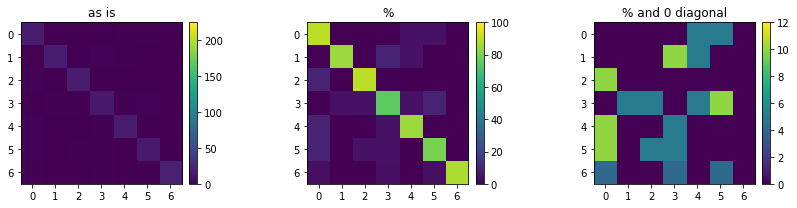

In [20]:
cmx_svm = confusion_matrix(y_test, best_pred)

plot_confusion_matrix(cmx, vmax1=225, vmax2=100, vmax3=12)

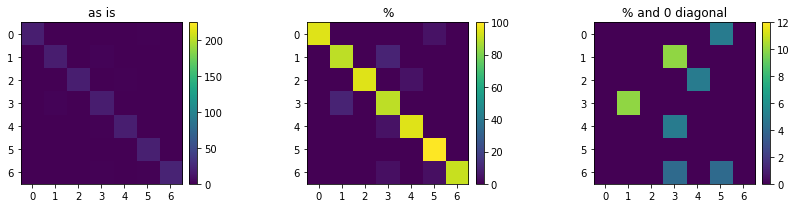

In [21]:
plot_confusion_matrix(cmx_svm, vmax1=225, vmax2=100, vmax3=12)

# Conclusion:
    En conclusion, nous avons construit un modèle de base pour classer les images en fonction de leurs caractéristiques HOG. De plus, nous avons mis en place notre outillage pour améliorer systématiquement le modèle de manière automatisée. Et surtout, cette méthodologie est générique et peut être appliquée à toutes sortes de problèmes d'apprentissage automatique.